# Fitting a simple model

We have created a dataset in the previous notebook, now it is time to use some data to fit a model.

In [ ]:
%load_ext autoreload
%autoreload 2
from logistic_growth.fitting import fit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


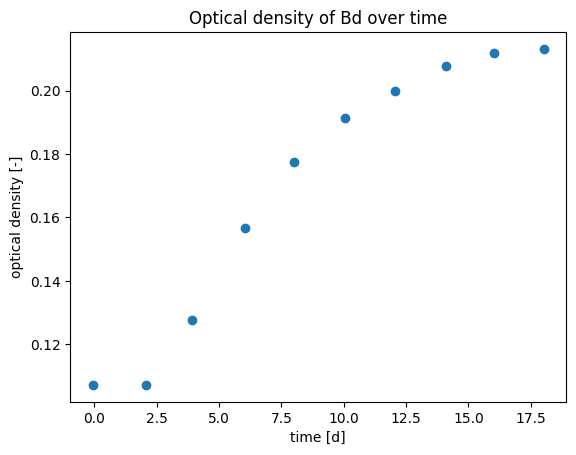

In [ ]:
fig, ax = fit.data.plot('t-OD')

In [ ]:
fit.data['t-OD'][0,1]

np.float64(0.10723981900452495)

In [ ]:
fit.simulator(fit.parameters)

TypeError: 'module' object is not subscriptable

We always need the same four ingredients to fit a model:

1. A dataset
2. An initial set of parameters
3. A simulator
4. A calibration algorithm


We can collect all of these ingredients in a `ModelFit` object, that will do some of the nitty gritty work for us in the background.

In [ ]:


fit = ModelFit()
fit.data = data # data
fit.parameters = 



def define_simulator(data):
    """
    This is a second-order function that takes data as input 
    and returns a simulator function as output. 

    This makes it possible to "engrain" information from the data 
    into the simulator, using a construct called [closure](https://en.wikipedia.org/wiki/Closure_(computer_programming)). 
    """

    observed_timepoints = data['t-OD'][:,0]
        
    def simulate_logistic(
        parameters, # proposed parameter values 
        t_eval = observed_timepoints
        ):

       
    
    return simulate_logistic

<>:53: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
<>:53: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
C:\Users\simon\AppData\Local\Temp\ipykernel_8692\2344753370.py:53: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
  y0 = [data['t-OD']][0,1] # initial conditions for the ODE


In [ ]:
fit.simulator = define_simulator(fit.data)
fit.simulator(fit.parameters)

[-0.0591133   2.08866995  3.92118227  6.02955665  8.01970443 10.04926108
 12.03940887 14.08866995 16.03940887 18.00985222]


TypeError: list indices must be integers or slices, not tuple

In [ ]:
fit.data

In [ ]:
fit.simulator()

In [ ]:
fit.defaultparams

Parameters(names=['r', 'K'], values=[0.2, 1.0], free=[True, True], units=['d^-1', '-'], labels=['growth rate', 'carrying capacity'])